In [18]:
%load_ext autoreload
%autoreload 2

# python
import os
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("ATLAS")
import pandas as pd
import sys
sys.path.append("../")

# custom
import Utils as ut
from Utils import loadALEPH2004Result, loadWeights, ensembleWeights, calc_hist, plotThrust
import dataloader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
aleph = ut.loadALEPH2004Result()
print(aleph["aleph_log_thrust_errs"])
print(aleph["aleph_log_thrust_errs"] - np.linalg.norm(aleph["aleph_log_thrust_errs_individual"], axis=1))

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -
[0.00059364 0.00761793 0.01701719 0.00781693 0.00746136 0.00677942
 0.00814534 0.0077546  0.0070463  0.00968856 0.00883575 0.00875478
 0.00948643 0.00881046 0.00790756 0.00968362 0.00909576 0.0086974
 0.0068823  0.00685199 0.00751772 0.00534918 0.00509836 0.00535912
 0.00636601 0.00561443 0.00563602 0.00609543 0.00640759 0.00483177
 0.00531451 0.00450477 0.00354568 0.00293204 0.00207306 0.00221681
 0.00172053 0.00111097 0.00080795 0.00057632 0.00050214 0.00029193]
[ 0.00000000e+00  0.00000000e+00  3.46944695e-18  0.00000000e+00
 -8.67361738e-19  0.00000000e+00  1.73472348e-18 -8.67361738e-19
 -8.67361738e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.73472348e-18
  1.73472348e-18 -1.73472348e-18  0.00000000e+00  8.67361738e-19
 -8.67361738e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.000000

/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:86: RuntimeWarning: divide by zero encountered in log
  aleph_log_bins = np.log(aleph_bins)


In [3]:
import json

with open("../training_conf.json") as f:
      training_conf = json.load(f)

# load thrust distributions
reco_data, reco_mc, gen_mc, pass_reco, pass_gen = dataloader.DataLoader(training_conf)

(1365440,) 1326338
(771597,) 751853


In [21]:
print(reco_mc.shape, pass_reco.shape, pass_reco.sum())
print(gen_mc.shape, pass_gen.shape, pass_gen.sum())

(973769, 1) (973769,) 751853
(973769, 1) (973769,) 973769


In [ ]:
# plotting configuration
conf = {
    "logtau" : {
        "aleph" : {
            "x" : aleph["aleph_log_midbins"], 
            "y": aleph["aleph_log_thrust"], 
            "xerr": aleph["aleph_log_binwidths"]/2, 
            "yerr": aleph["aleph_log_thrust_errs"], 
            "bins" : aleph["aleph_log_bins"]
        },
        "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/dlog(1-T)",
        "ax1_yscale" : "log",
        "ax2_xscale" : "linear",
        "ax1_ylim" : [0.2*10**-5, 10**0],
        "ax2_xlabel" : r"$\log(\tau)$",
        "ax2_ylim" : [0.01, 1.99],
        "bins" : np.linspace(aleph["log_bins_min"], np.log(0.5), 51),
        "legend" : "lower right",
        "legend_bbox" : (0.98, 0.0)
    },
}    

In [ ]:
# histogram logtau distribution for reco, gen, and unifold closure
bins = conf["logtau"]["bins"]
# mc reco histograms
h_reco_mc = calc_hist(reco_mc, bins=bins, density=True)
# gen before histograms
h_gen_mc = calc_hist(gen_mc, bins=bins, density=True)

In [24]:
# get weights
weightsPath = "/global/homes/b/badea/aleph/unfold-ee-logtau/results/training-81fab728/f0852342/model_weights_75193818/"
weights_starting = np.load(os.path.join(weightsPath, "starting_weights.npz"))["weights_mc"].flatten()
weights_step1 = np.load(os.path.join(weightsPath, "omnifold_weights_reco.npy")).flatten()
weights_step2 = np.load(os.path.join(weightsPath, "omnifold_weights.npy")).flatten()

# multiply
weights_step1 *= weights_starting
weights_step2 *= weights_starting

# unifold closure histograms
h_unifold_step1_mc = calc_hist(reco_mc[pass_reco].flatten(), bins=bins, density=True, weights=weights_step1[pass_reco])
h_unifold_step2_mc = calc_hist(gen_mc.flatten(), bins=bins, density=True, weights=weights_step2)

/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:144: RuntimeWarning: divide by zero encountered in divide
  ratio = A / B
/global/u1/b/badea/aleph/unfold-ee-logtau/Plotting/Utils.py:144: RuntimeWarning: invalid value encountered in divide
  ratio = A / B


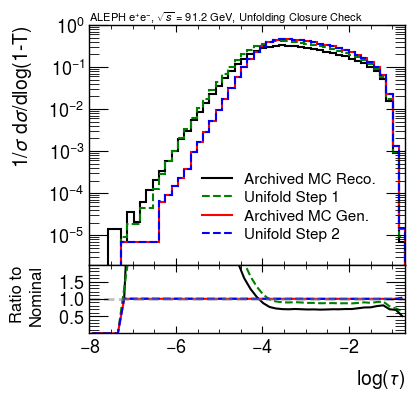

In [30]:
# style
val = conf["logtau"]
style = {
    "legend_loc" : val["legend"],
    "legend_bbox" : val["legend_bbox"],
    "legend_ncol" : 1,
    "legend_fontsize" : 11,
    "ax1_ylabel" : val["ax1_ylabel"],
    "ax1_yscale" : val["ax1_yscale"],
    "ax2_xlabel" : val["ax2_xlabel"],
    "ax2_xscale" : val["ax2_xscale"],
    "ax2_ylabel" : f'Ratio to\nNominal',
    "ax1_ylim" : val["ax1_ylim"],
    "bins" : bins,
    "ax2_ylim" : val["ax2_ylim"],
}

binwidths = bins[1:] - bins[:-1]
bin_centers = (bins[:-1] + bins[1:]) / 2

# plot
inPlots = {}
inPlots["reco_mc"] = {"plotType": "stairs", "x": bins, "y": h_reco_mc[0], "color": "black", "label": "Archived MC Reco.", "ls" : "-"}
inPlots["unifold_step1"] = {"plotType": "stairs", "x": bins, "y": h_unifold_step1_mc[0], "color": "green", "label": "Unifold Step 1", "ls" : "--"}
inPlots["gen_mc"] = {"plotType": "stairs", "x": bins, "y": h_gen_mc[0], "color": "red", "label": "Archived MC Gen.", "ls" : "-"}
inPlots["unifold_step2"] = {"plotType": "stairs", "x": bins, "y": h_unifold_step2_mc[0], "color": "blue", "label": "Unifold Step 2", "ls" : "--"}

# ratio denominator using the total error
ratio_denom = [[h_gen_mc[0]],]

header = r"ALEPH e$^{+}$e$^{-}$, $\sqrt{s}$ = 91.2 GeV, Unfolding Closure Check"
fig, (ax1, ax2) = plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10, header=header)
plt.savefig("logtau_unifold_closure.pdf", bbox_inches="tight")
plt.show()
plt.close()